# Numerical Stability and Initialization

$$
\mathbf{h}^{(l)}=f_{l}\left(\mathbf{h}^{(l-1)}\right) \text { and thus } \mathbf{o}=f_{L} \circ \ldots \circ f_{1}(\mathbf{x})
$$

$$
\frac{\partial \ell}{\partial \mathbf{W}^{t}}=\frac{\partial \ell}{\partial \mathbf{h}^{d}} \frac{\partial \mathbf{h}^{d}}{\partial \mathbf{h}^{d-1}} \ldots \frac{\partial \mathbf{h}^{t+1}}{\partial \mathbf{h}^{t}} \frac{\partial \mathbf{h}^{t}}{\partial \mathbf{W}^{t}}
$$

- exploding gradient
- vanishing gradient
- MLP

$$
f_{t}\left(\mathbf{h}^{t-1}\right)=\sigma\left(\mathbf{W}^{t} \mathbf{h}^{t-1}\right)
$$

$$
\frac{\partial \mathbf{h}^{t}}{\partial \mathbf{h}^{t-1}}=\operatorname{diag}\left(\sigma^{\prime}\left(\mathbf{W}^{t} \mathbf{h}^{t-1}\right)\right)\left(W^{t}\right)^{T}
$$

$$
\prod_{i=t}^{d-1} \frac{\partial \mathbf{h}^{i+1}}{\partial \mathbf{h}^{i}}=\prod_{i=t}^{d-1} \operatorname{diag}\left(\sigma^{\prime}\left(\mathbf{W}^{i} \mathbf{h}^{i-1}\right)\right)\left(W^{i}\right)^{T}
$$

- ReLU

$$
\sigma(x)=\max (0, x) \quad \text { and } \quad \sigma^{\prime}(x)= \begin{cases}1 & \text { if } x>0 \\ 0 & \text { otherwise }\end{cases}
$$

- $\displaystyle \prod_{i=t}^{d-1} \frac{\partial \mathbf{h}^{i+1}}{\partial \mathbf{h}^{i}}$ comes from $\prod_{i=t}^{d-1} \left(W^{i}\right)^{T}$
- exploding gradient will take place if $d - t$ is big
    - infinty
    - sensitive to learning rate

- Sigmoid

$$
\sigma(x)=\frac{1}{1+e^{-x}} \quad \sigma^{\prime}(x)=\sigma(x)(1-\sigma(x))
$$

- $\displaystyle \prod_{i=t}^{d-1} \frac{\partial \mathbf{h}^{i+1}}{\partial \mathbf{h}^{i}}$ may equals to the product of small value numbers, $0.8^{100} \approx 2 \times 10^{-10}$
- vanishing gradient
    - no effect progress in training
    - not suitable for deep network

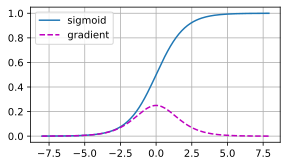

In [1]:
import torch
from d2l import torch as d2l

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

In [2]:
M = torch.normal(0, 1, size=(4,4))
print('a single matrix \n',M)
for i in range(100):
    M = torch.mm(M, torch.normal(0, 1, size=(4, 4)))

print('after multiplying 100 matrices\n', M)

a single matrix 
 tensor([[-1.3250, -0.0503, -0.2145,  1.3744],
        [ 0.1505, -0.8760, -1.0494,  1.0923],
        [-1.2465, -0.0822,  1.3392, -1.2532],
        [-0.8656,  0.4941,  0.5706, -1.1309]])
after multiplying 100 matrices
 tensor([[-3.4641e+23,  5.1221e+22, -8.4135e+23,  1.2253e+22],
        [ 1.6229e+23, -2.3997e+22,  3.9417e+23, -5.7404e+21],
        [-1.0558e+23,  1.5611e+22, -2.5642e+23,  3.7344e+21],
        [-8.4699e+22,  1.2524e+22, -2.0571e+23,  2.9959e+21]])


- control the range of gradients $[1e-6, 1e3]$
- change multiplying to adding
- normalizing the gradient
- clipping

- view gradients as variables
- forward

$$
\begin{aligned}
\mathbb{E}\left[h_{i}^{t}\right] &=0 \\
\operatorname{Var}\left[h_{i}^{t}\right] &=a
\end{aligned}
$$

- backward

$$
\mathbb{E}\left[\frac{\partial \ell}{\partial h_{i}^{t}}\right]=0 \quad \operatorname{Var}\left[\frac{\partial \ell}{\partial h_{i}^{t}}\right]=b \quad \forall i, t
$$


### forward

$$
\mathbb{E}\left[h_{i}^{t}\right]=\mathbb{E}\left[\sum_{j} w_{i, j}^{t} h_{j}^{t-1}\right]=\sum_{j} \mathbb{E}\left[w_{i, j}^{t}\right] \mathbb{E}\left[h_{j}^{t-1}\right]=0
$$

$$
\begin{aligned}
\operatorname{Var}\left[h_{i}^{t}\right] &=\mathbb{E}\left[\left(h_{i}^{t}\right)^{2}\right]-\mathbb{E}\left[h_{i}^{t}\right]^{2}=\mathbb{E}\left[\left(\sum_{j} w_{i, j}^{t} h_{j}^{t-1}\right)^{2}\right] \\
&=\mathbb{E}\left[\sum_{j}\left(w_{i, j}^{t}\right)^{2}\left(h_{j}^{t-1}\right)^{2}+\sum_{j \neq k} w_{i, j}^{t} w_{i, k}^{t} h_{j}^{t-1} h_{k}^{t-1}\right] \\
&=\sum_{j} \mathbb{E}\left[\left(w_{i, j}^{t}\right)^{2}\right] \mathbb{E}\left[\left(h_{j}^{t-1}\right)^{2}\right] \\
&=\sum_{j} \operatorname{Var}\left[w_{i, j}^{t}\right] \operatorname{Var}\left[h_{j}^{t-1}\right]=n_{t-1} \gamma_{t} \operatorname{Var}\left[h_{j}^{t-1}\right]
\end{aligned}
$$

$$
\Rightarrow\quad n_{t-1} \gamma_{t} = 1
$$


### backward

$$
\begin{aligned}
&\frac{\partial \ell}{\partial \mathbf{h}^{t-1}}=\frac{\partial \ell}{\partial \mathbf{h}^{t}} \mathbf{W}^{t} \quad\Rightarrow\quad\left(\frac{\partial \ell}{\partial \mathbf{h}^{t-1}}\right)^{T}=\left(W^{t}\right)^{T}\left(\frac{\partial \ell}{\partial \mathbf{h}^{t}}\right)^{T} \\\\
&\mathbb{E}\left[\frac{\partial \ell}{\partial h_{i}^{t-1}}\right]=0 \\\\
&\operatorname{Var}\left[\frac{\partial \ell}{\partial h_{i}^{t-1}}\right]=n_{t} \gamma_{t} \operatorname{Var}\left[\frac{\partial \ell}{\partial h_{j}^{t}}\right] \quad\Rightarrow\quad  n_{t} \gamma_{t}=1
\end{aligned}
$$


$$
\sigma(x) = \alpha x  + \beta
$$

$$
\begin{array}{rlr}
\mathbb{E}\left[h_{i}^{t}\right] & =\mathbb{E}\left[\alpha h_{i}^{\prime}+\beta\right]=\beta &\Rightarrow\quad \beta=0 \\
\operatorname{Var}\left[h_{i}^{t}\right] & =\mathbb{E}\left[\left(h_{i}^{t}\right)^{2}\right]-\mathbb{E}\left[h_{i}^{t}\right]^{2} \\
& =\mathbb{E}\left[\left(\alpha h_{i}^{\prime}+\beta\right)^{2}\right]-\beta^{2} \\
& =\mathbb{E}\left[\alpha^{2}\left(h_{i}^{\prime}\right)^{2}+2 \alpha \beta h_{i}^{\prime}+\beta^{2}\right]-\beta^{2} &\Rightarrow\quad  \alpha=1 \\
& =\alpha^{2} \operatorname{Var}\left[h_{i}^{\prime}\right]
\end{array}
$$

### Activation Functions

$$
\begin{aligned}
\operatorname{sigmoid}(x) &=\frac{1}{2}+\frac{x}{4}-\frac{x^{3}}{48}+O\left(x^{5}\right) \\
\tanh (x) &=0+x-\frac{x^{3}}{3}+O\left(x^{5}\right) \\
\operatorname{relu}(x) &=0+x \quad \text { for } x \geq 0
\end{aligned}
$$

- adjust the $\operatorname{sigmoid}(x)$ function

$$
4\times \operatorname{sigmoid}(x)  - 2
$$


### Parameter Initialization

- One way of addressing—or at least mitigating—the issues raised above is through careful initialization. Additional care during optimization and suitable regularization can further enhance stability.

### Default Initialization

- In the previous sections, e.g., we used a normal distribution to initialize the values of our weights. If we do not specify the initialization method, the framework will use a default random initialization method, which often works well in practice for moderate problem sizes.

### Xavier Initialization

- The weights $\omega_{i,j}$ are all drawn independently from the same distribution. Furthermore, let us assume that this distribution has zero mean and variance $\sigma^2$. Note that this does not mean that the distribution has to be Gaussian, just that the mean and variance need to exist. For now, let us assume that the inputs to the layer $x_j$ also have zero mean and variance $\gamma^2$ and that they are independent of $\omega_{i,j}$ and independent of each other. In this case, we can compute the mean and variance of $o_i$ as follows:

$$
\begin{aligned}
E\left[o_{i}\right] &=\sum_{j=1}^{n_{\text {II }}} E\left[w_{i j} x_{j}\right] \\
&=\sum_{j=1}^{n_{\text {in }}} E\left[w_{i j}\right] E\left[x_{j}\right] \\
&=0, \\
\operatorname{Var}\left[o_{i}\right] &=E\left[o_{i}^{2}\right]-\left(E\left[o_{i}\right]\right)^{2} \\
&=\sum_{j=1}^{n_{\text {in }}} E\left[w_{i j}^{2} x_{j}^{2}\right]-0 \\
&=\sum_{j=1}^{n_{\text {in }}} E\left[w_{i j}^{2}\right] E\left[x_{j}^{2}\right] \\
&=n_{\text {in }} \sigma^{2} \gamma^{2} .
\end{aligned}
$$

- Using the same reasoning as for forward propagation, we see that the gradients’ variance can blow up unless $n_{out}\sigma^2 = 1$

$$
\frac{1}{2}\left(n_{\text {in }}+n_{\text {out }}\right) \sigma^{2}=1 \text { or equivalently } \sigma=\sqrt{\frac{2}{n_{\text {in }}+n_{\text {out }}}}
$$

- Typically, the Xavier initialization samples weights from a Gaussian distribution with zero mean and variance $\displaystyle \sigma^2 = \frac{2}{n_{in} + n_{out}} $
- We can also adapt Xavier’s intuition to choose the variance when sampling weights from a uniform distribution $ \displaystyle   U\left(-\sqrt{\frac{6}{n_{\text {in }}+n_{\text {out }}}}, \sqrt{\frac{6}{n_{\text {in }}+n_{\text {out }}}}\right)$
